# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import time

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        
        svm = LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=learning_rate, 
                              reg=regularization_strength,
                              num_iters=1500, verbose=True)
        toc = time.time()
        print('That took %fs' % (toc - tic))

        y_train_pred = svm.predict(X_train_feats)
        training_accuracy =np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        validation_accuracy =np.mean(y_val == y_val_pred)
        
        results[(learning_rate, regularization_strength)]=(training_accuracy, validation_accuracy)
        
        if best_val==-1 or best_val>loss_hist[-1]:
            best_val = loss_hist[-1]   # The highest validation accuracy that we have seen so far.
            best_svm = svm
                             

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 92.259881
iteration 100 / 1500: loss 90.612348
iteration 200 / 1500: loss 88.994621
iteration 300 / 1500: loss 87.426025
iteration 400 / 1500: loss 85.862894
iteration 500 / 1500: loss 84.340738
iteration 600 / 1500: loss 82.844667
iteration 700 / 1500: loss 81.380493
iteration 800 / 1500: loss 79.946208
iteration 900 / 1500: loss 78.551667
iteration 1000 / 1500: loss 77.172968
iteration 1100 / 1500: loss 75.826284
iteration 1200 / 1500: loss 74.505055
iteration 1300 / 1500: loss 73.208931
iteration 1400 / 1500: loss 71.925577
That took 0.820397s
iteration 0 / 1500: loss 816.697386
iteration 100 / 1500: loss 670.223398
iteration 200 / 1500: loss 550.311946
iteration 300 / 1500: loss 452.142231
iteration 400 / 1500: loss 371.774604
iteration 500 / 1500: loss 305.989361
iteration 600 / 1500: loss 252.125656
iteration 700 / 1500: loss 208.037228
iteration 800 / 1500: loss 171.938368
iteration 900 / 1500: loss 142.392236
iteration 1000 / 1500: loss 118.201823
itera

In [5]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


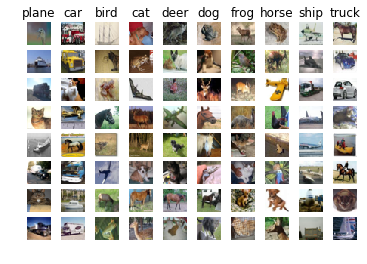

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
Yes the missclassified images remind you of the missclassfied class. They have similar shape and background.



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [35]:
from cs231n.classifiers.neural_net import TwoLayerNet
import pprint
pp=pprint.pprint

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden
'''
# Use of random search for hyperparameter search
for i in range(20):
    lr, reg, hidden_dim = generate_random_hyperparams(-1, 0, -7, -4, 10, 500)
    # Create a two-layer network
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=3000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train_feats) == y_train).mean()
    
    # Predict on the validation set
    val_accuracy = (net.predict(X_val_feats) == y_val).mean()
    
    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_dim, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
'''

init_params={
    'hidden_size':500,
    'num_iters':3000,
    'learning_rate':1e-2,
    'learning_rate_decay':0.95,
    'reg':0.25/10
}
'''
init_params={
    'hidden_size':206,
    'num_iters':3000,
        'learning_rate':1e-3*10,
   # 'learning_rate':2.7e-1,
    'learning_rate_decay':0.95,
        'reg':0.25/10
#    'reg':0.25e-4
}
'''


interval_params={
    'hidden_size':{'min':100, 'max':2000},
    'num_iters':{'min':1000, 'max':2000},
    'learning_rate':{'min':1e-6, 'max': 1e-2},
    'learning_rate_decay':{'min':0.5, 'max':1},
    'reg':{'min':1e-7, 'max':2}
}


class Search:
    def __init__(self, interval_params, X_train, X_val):
        self.X_train = X_train
        self.X_val = X_val
        self.interval_params = interval_params

    def evaluate(self, current_params, key, step, current_acc):

        plus = dict(current_params)
        minus = dict(current_params)

        plus_pre  = plus[key]
        minus_pre = minus[key]
        
        plus[key] =  min(plus[key]*step, self.interval_params[key]['max'])
        minus[key] = max(minus[key]/step, self.interval_params[key]['min'])
        
        # Change key paramater 

        plus_step = plus[key] - plus_pre
        minus_step = minus[key] - minus_pre

        print(key, minus[key], current_params[key], plus[key], minus_step, plus_step)
        
        plus_acc, plus_net  = self.train(plus)
        minus_acc, minus_net = self.train(minus)
        
        print(minus_acc, current_acc, plus_acc)
        
        if current_acc>plus_acc and current_acc>minus_acc:
            return  {'param_change':0, 'acc_change_relative_current':0}
        elif plus_acc>minus_acc and plus[key]>current_params[key]:
            return  {
                'param_change':plus_step,  
                'plus_acc':plus_acc,
                'best_acc':plus_acc,
                'best_net':plus_net,
                'current_acc':current_acc,
                'acc_change_relative_current':(plus_acc-current_acc)/current_acc
            }
        elif plus_acc<minus_acc and minus[key]<current_params[key]:
            return {
                'param_change':minus_step, 
                'best_acc':minus_acc,
                'best_net':minus_net,
                'minus_acc':minus_acc,
                'current_acc':current_acc,
                'acc_change_relative_current': (minus_acc-current_acc)/current_acc
            }
        else:
             return  {'param_change':0, 'acc_change_relative_current':0}


    def train(self, p):
       
        input_size = self.X_train.shape[1] #32 * 32 * 3
        hidden_size = int(p['hidden_size'])
        num_classes = 10
        

        net = TwoLayerNet(input_size, hidden_size, num_classes)

        # Train the network
        stats = net.train(self.X_train, y_train, self.X_val, y_val,
                          num_iters=int(p['num_iters']),
                          batch_size=200,
                          learning_rate=p['learning_rate'], 
                          learning_rate_decay=p['learning_rate_decay'],
                          reg= p['reg'], 
                          verbose=False)

        # Predict on the validation set
        val_acc = (net.predict(self.X_val) == y_val).mean()
            
        return val_acc, net
    
    def run(self, init_params, n_iterations, step):
        
        best_acc=None
        best_net=None
        step_init=step
    
        best_params=dict(init_params)
        
        best_acc, best_net = self.train(best_params)
        
        i=0
        while i<n_iterations and 1 < step :
        
            res={}
    
            print(best_acc)
            pp( best_params)
    
            keys=[
                'hidden_size',
                'num_iters',
                'learning_rate',
                'learning_rate_decay',
                'reg'
            ]
        
            for key in keys:
                res[key] = self.evaluate(best_params, key, step, best_acc)
            
            items = list(res.items())
            change = list(map(lambda x:x[1]['acc_change_relative_current'], items))
            
            print(change)
            pp(items)
            
            max_change = max(change)
            index_max = np.argmax(change)
            
            item_max=items[index_max]
            
            print('Item max', item_max, index_max)
            
            key = item_max[0]
            
            if max_change and (not best_acc or res[key]['best_acc']>best_acc):
                best_acc = res[key]['best_acc']
                best_net = res[key]['best_net']

                res[key]['acc_change_relative_max'] = res[key]['acc_change_relative_current']/max_change
                res[key]['param_change_scaled_acc'] = res[key]['param_change']*res[key]['acc_change_relative_max']

                best_params[key]+=res[key]['param_change_scaled_acc']

                print(key)
                pp(res[key])

                step=step*1.1
                print('Step increase', step)

            else:

                step=step*0.9
                print('Step decrease', step)
            

#            print(best_net)
            
            i+=1
        return best_net, best_params, best_acc
    
    
search = Search(interval_params, X_train_feats, X_val_feats )  

res = search.train(init_params)
pp(res)

best_net = search.run(init_params, 50, 20)

init_params={
    'hidden_size':206,
    'num_iters':3000,
    'learning_rate':2.7e-1,
    'learning_rate_decay':0.95,
    'reg':0.25/2
}


print('done')

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


(0.224, <cs231n.classifiers.neural_net.TwoLayerNet object at 0x7f75ef839d50>)
0.225
{'hidden_size': 500,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'num_iters': 3000,
 'reg': 0.025}
hidden_size 100 500 2000 -400 1500
0.201 0.225 0.262
num_iters 1000 3000 2000 -2000 -1000
0.079 0.225 0.159
learning_rate 0.0005 0.01 0.01 -0.0095 0.0
0.078 0.225 0.233
learning_rate_decay 0.5 0.95 1 -0.44999999999999996 0.050000000000000044
0.119 0.225 0.292
reg 0.00125 0.025 0.5 -0.02375 0.475
0.271 0.225 0.079
[0.16444444444444448, 0, 0, 0.29777777777777764, 0.20444444444444448]
[('hidden_size',
  {'acc_change_relative_current': 0.16444444444444448,
   'best_acc': 0.262,
   'best_net': <cs231n.classifiers.neural_net.TwoLayerNet object at 0x7f75ea5c6290>,
   'current_acc': 0.225,
   'param_change': 1500,
   'plus_acc': 0.262}),
 ('num_iters', {'acc_change_relative_current': 0, 'param_change': 0}),
 ('learning_rate', {'acc_change_relative_current': 0, 'param_change': 0}),
 ('learning_rate_decay

KeyboardInterrupt: 

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)